## Dimensionality reduction with principle components

**Principle component analysis**, or **PCA**, is an alternative to regularization and straight-forward feature elimination. PCA is particularly useful for problems with very large numbers of features compared to the number of training cases. For example, when faced with a problem with many thousands of features and perhaps a few thousand cases, PCA can be a good choice to **reduce the dimensionality** of the feature space.  

PCA is one of a family of transformation methods that reduce dimensionality. PCA is the focus here, since it is the most widely used of these methods. 

The basic idea of PCA is rather simple: Find a linear transformation of the feature space which **projects the majority of the variance** onto a few orthogonal dimensions in the transformed space. The PCA transformation maps the data values to a new coordinate system defined by the principle components. Assuming the highest variance directions, or **components**, are the most informative, low variance components can be eliminated from the space with little loss of information. 

The projection along which the greatest variance occurs is called the **first principle component**. The next projection, orthogonal to the first, with the greatest variance is call the **second principle component**. Subsequent components are all mutually orthogonal with decreasing variance along the projected direction.  

Widely used PCA algorithms compute the components sequentially, starting with the first principle component. This means that it is computationally efficient to compute the first several components from a very large number of features. Thus, PCA can make problems with very large numbers of features computationally tractable. 

****
**Note:** It may help your understanding to realize that principle components are a scaled version of the **eigenvectors** of the feature matrix. The scale for each dimensions is given by the **eigenvalues**. The eigenvalues are the fraction of the variance explained by the components. 
****

In [13]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.decomposition as skde
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

(1000, 35)
(1000, 1)


In [14]:
## Compute the principle components

pca_mod = skde.PCA()
pca_comps = pca_mod.fit(X_train)
# Print the variance explained for each component and the sum of the variance explained
print(pca_comps.explained_variance_ratio_)
print(np.sum(pca_comps.explained_variance_ratio_))
# The explained variance of the first component is many times larger than for the second component
# The variance ratios are in descending order and that the sum is 1.0

[2.14454905e-01 1.45271147e-01 1.28532553e-01 5.55554330e-02
 4.91723911e-02 4.27625372e-02 3.78015441e-02 3.52905162e-02
 3.40935676e-02 2.98736044e-02 2.82623202e-02 2.63144677e-02
 2.40299754e-02 2.20162922e-02 1.72330465e-02 1.70031525e-02
 1.60567422e-02 1.37503175e-02 1.27040327e-02 1.02826434e-02
 9.12460219e-03 7.13807162e-03 6.43465948e-03 6.29150307e-03
 3.93792720e-03 2.95950712e-03 1.54556112e-03 1.20102653e-03
 9.05952167e-04 4.22937727e-32 2.48558805e-33 1.22248933e-33
 1.22248933e-33 1.22248933e-33 1.79044130e-34]
1.0


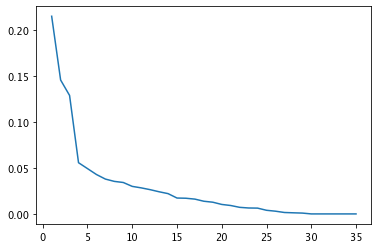

In [15]:
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(1, len(comps)+1)
    x = [y for y in x]          
    plt.plot(x,comps)
    
'''
This curve is often referred to as a scree plot. 
Notice that the explained variance decreases rapidly until the 5th component and then slowly, thereafter. 
The first few components explain a large fraction of the variance and therefore contain much of the explanatory information in the data. 
The components with small explained variance are unlikely to contain much explanatory information. 
Often the inflection point or 'knee' in the scree curve is used to choose the number of components selected.
'''

plot_explained(pca_comps)

In [16]:
## Choose the first five components
pca_mod_5 = skde.PCA(n_components = 5)
pca_mod_5.fit(X_train)
Comps_5 = pca_mod_5.transform(X_train)
print(Comps_5.shape)

## Define and fit the logistic regression model
log_mod_5 = linear_model.LogisticRegression(C = 10.0, class_weight = {0:0.45, 1:0.55}) 
log_mod_5.fit(Comps_5, y_train)
print(log_mod_5.intercept_)
print(log_mod_5.coef_)

(700, 5)
[-0.79842087]
[[ 0.3519093  -0.03071839 -0.41909606  0.87187666 -0.65355706]]


In [17]:
## Add more components to the model
pca_mod_10 = skde.PCA(n_components = 10)
pca_mod_10.fit(X_train)
Comps_10 = pca_mod_10.transform(X_train)
Comps_10.shape

## Define and fit the logistic regression model
log_mod_10 = linear_model.LogisticRegression(C = 10.0, class_weight = {0:0.45, 1:0.55}) 
log_mod_10.fit(Comps_10, y_train)
print(log_mod_10.intercept_)
print(log_mod_10.coef_)

[-0.85858219]
[[ 0.3749884  -0.03139241 -0.44731659  0.90714606 -0.65611929 -0.29079882
   0.34824185  0.70228824  0.34928326  0.11901002]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive       122                90
Actual negative        17                71

Accuracy        0.64
AUC             0.76
Macro precision 0.66
Macro recall    0.69
 
           Positive      Negative
Num case      212            88
Precision    0.88          0.44
Recall       0.58          0.81
F1           0.70          0.57


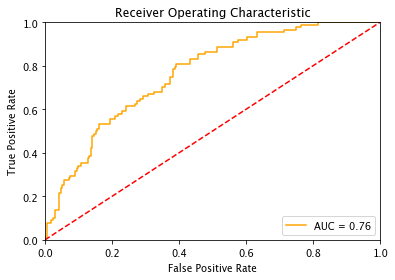

                 Confusion matrix
                 Score positive    Score negative
Actual positive       131                81
Actual negative        15                73

Accuracy        0.68
AUC             0.80
Macro precision 0.69
Macro recall    0.72
 
           Positive      Negative
Num case      212            88
Precision    0.90          0.47
Recall       0.62          0.83
F1           0.73          0.60


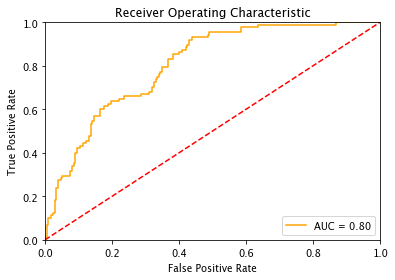

In [20]:
## Evaluate those two models with different numbers of components

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    

probabilities = log_mod_5.predict_proba(pca_mod_5.transform(X_test))
print_metrics(y_test, probabilities, 0.3)    
plot_auc(y_test, probabilities)   

probabilities = log_mod_10.predict_proba(pca_mod_10.transform(X_test))
print_metrics(y_test, probabilities, 0.3)  
plot_auc(y_test, probabilities)  

# All of the metrics have improved compared to the 5 component model. 
# Apparently there is useful information in the first 10 components.

In [23]:
def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))
    
    
# Perform cross validation on the result to find is this difference between 5 and 10 components really significant
# Ideally, the fitting of the PCA model should be part of the cross validation process.
    
Labels = Labels.reshape(Labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']

pca_mod = skde.PCA(n_components = 5)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_5, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)  

pca_mod = skde.PCA(n_components = 10)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_10, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)  

# Compare the AUC and its standard deviation obtained above to the AUC of the 5 component model. 
# The difference does appear to be significant. 
# This difference supports the hypothesis that the first 10 components all contain useful information

         Precision     Recall       AUC
Fold  1    0.690        0.633      0.756
Fold  2    0.599        0.581      0.724
Fold  3    0.702        0.660      0.790
Fold  4    0.633        0.636      0.650
Fold  5    0.716        0.631      0.760
Fold  6    0.672        0.626      0.737
Fold  7    0.599        0.581      0.647
Fold  8    0.702        0.660      0.769
Fold  9    0.737        0.674      0.760
Fold 10    0.609        0.600      0.707
----------------------------------------
Mean       0.666        0.628      0.730
Std        0.049        0.031      0.047
         Precision     Recall       AUC
Fold  1    0.702        0.698      0.767
Fold  2    0.738        0.729      0.800
Fold  3    0.642        0.612      0.789
Fold  4    0.624        0.617      0.703
Fold  5    0.716        0.676      0.807
Fold  6    0.686        0.662      0.790
Fold  7    0.610        0.612      0.674
Fold  8    0.726        0.721      0.815
Fold  9    0.713        0.705      0.765
Fold 10    0.635  

## Summary

Applied principle component analysis to dimensionality reduction for supervised machine learning. The first components computed contain most of the available information. When faced with large number of features, PCA is an effective way to make supervised machine learning models tractable. 

Specifically in this lab you have:
1. Computed PCA models with different numbers of components.
2. Compared logistic regression models with different numbers of components. In this case, using 10 components produced a significantly better model. Using 10 components is a useful reduction in dimensionality compared to the original 35 features. 